In [10]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.0 MB/s eta 0:00:00


In [11]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.6 MB/s eta 0:00:00


In [12]:
import pandas as pd
import torch
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import demoji
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nlpaug.augmenter.word as naw

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings

In [ ]:
import sqlite3

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("flipkart_products.db")
items = pd.read_sql_query("SELECT * from items", con)
con.close()

In [ ]:
items.head()

,product_id,product_name,price,category,sub_category,specifications,ratings,discount,moreinfo
0,ECMB000001,"Redmi 9A (SeaBlue, 32 GB)","₹7,413",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,3.0,/redmi-9a-seablue-32-gb/p/itmeabd39a0cd669?pid...
1,ECMB000002,"Redmi 9A (Midnight Black, 32 GB)","₹7,421",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,3.0,/redmi-9a-midnight-black-32-gb/p/itmeabd39a0cd...
2,ECMB000003,"Redmi 9A (Nature Green, 32 GB)","₹7,384",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,4.0,/redmi-9a-nature-green-32-gb/p/itmeabd39a0cd66...
3,ECMB000004,"Redmi 9 (Carbon Black, 64 GB)","₹10,745",Electronics,Mobile,4 GB RAM | 64 GB ROM16.59 cm (6.53 inch) HD+ D...,4.2,None,/redmi-9-carbon-black-64-gb/p/itm4fb151383983b...
4,ECMB000005,"Redmi 9 (Sky Blue, 64 GB)","₹10,489",Electronics,Mobile,4 GB RAM | 64 GB ROM16.59 cm (6.53 inch) HD+ D...,4.2,None,/redmi-9-sky-blue-64-gb/p/itm4fb151383983b?pid...


In [ ]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   product_id      82 non-null     object
 1   product_name    82 non-null     object
 2   price           82 non-null     object
 3   category        82 non-null     object
 4   sub_category    82 non-null     object
 5   specifications  82 non-null     object
 6   ratings         82 non-null     object
 7   discount        34 non-null     object
 8   moreinfo        82 non-null     object
dtypes: object(9)
memory usage: 5.9+ KB


In [ ]:
db = sqlite3.connect("flipkart_products.db")

df = pd.read_sql_query("SELECT * from ECMB000001", db)

for i in range(2, len(items) + 1):

    df_temp = pd.read_sql_query("SELECT * from ECMB{:06d}".format(i), db)
    df = pd.concat([df, df_temp])
con.close()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53493 entries, 0 to 289
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  53493 non-null  object
 1   review_id   53493 non-null  object
 2   title       53493 non-null  object
 3   review      53493 non-null  object
 4   likes       53493 non-null  object
 5   dislikes    53493 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    53493 non-null  object
dtypes: object(8)
memory usage: 3.7+ MB


<Figure size 2500x2000 with 0 Axes>

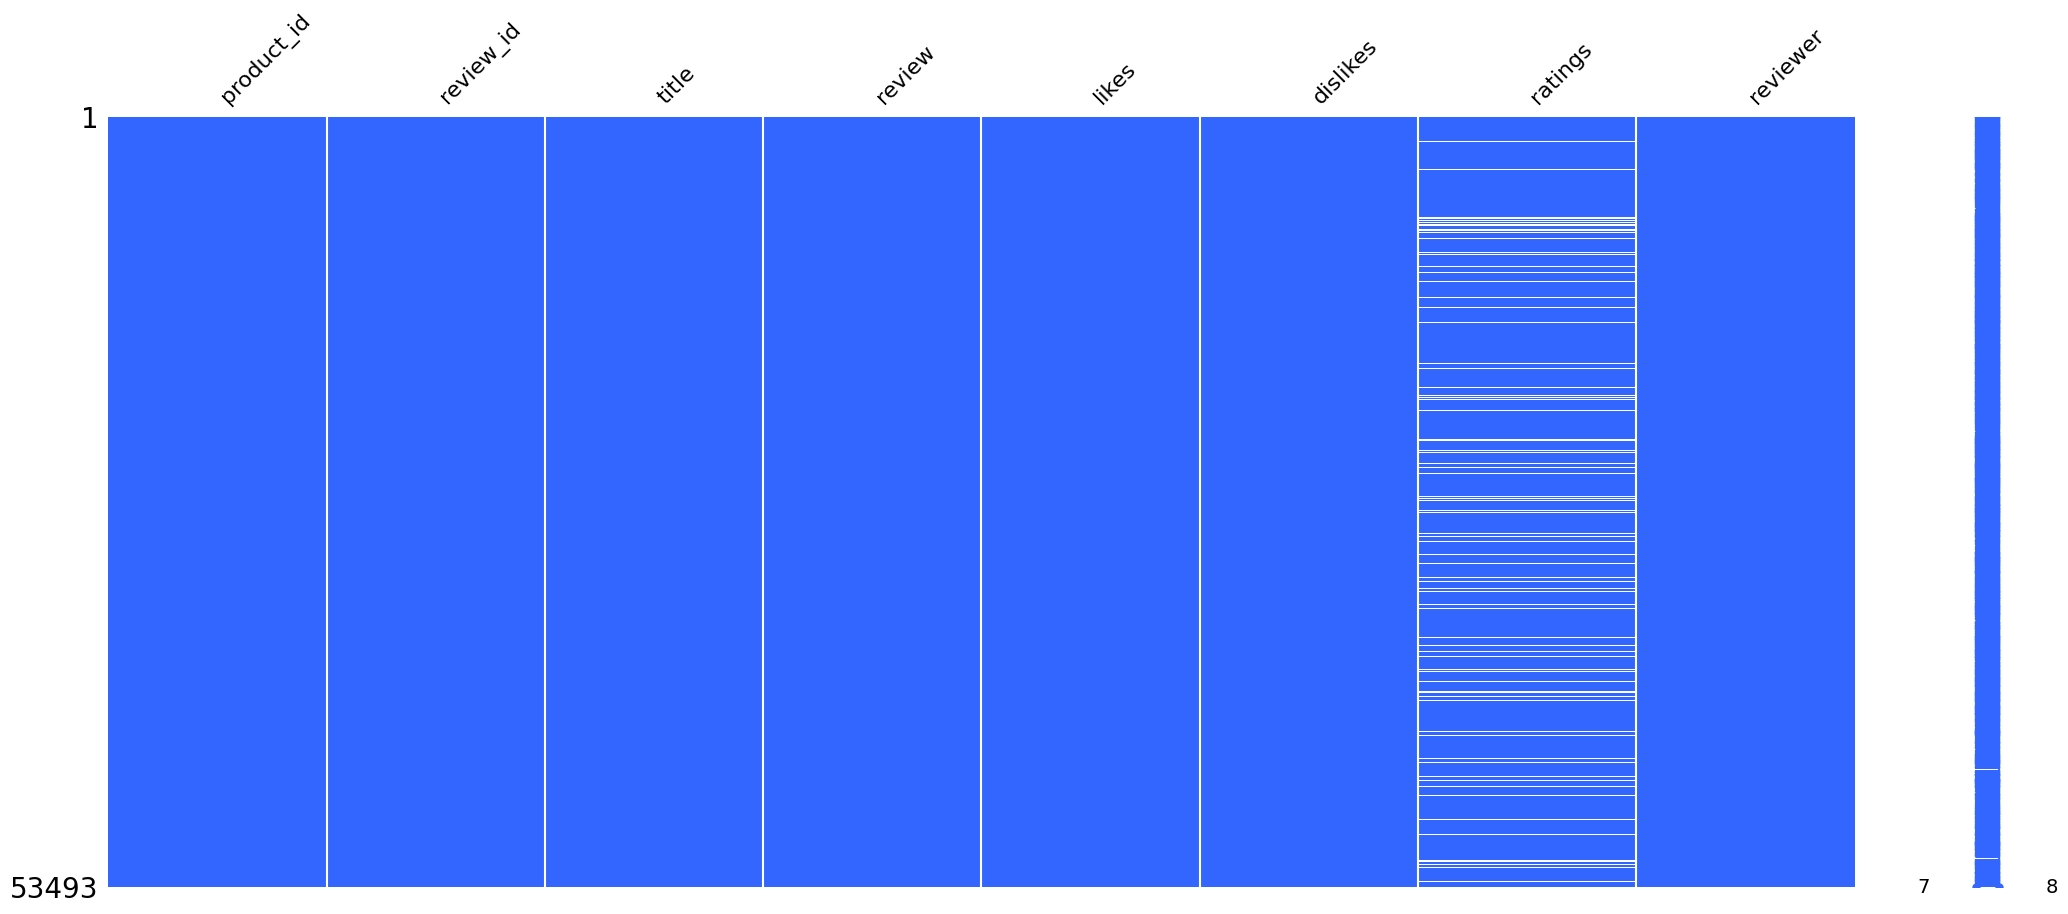

In [15]:
import missingno as msno
plt.figure(figsize=(25, 20))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()

In [16]:
# Dropping the rows with missing values

df.dropna(inplace=True, axis=0)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48488 entries, 0 to 287
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  48488 non-null  object
 1   review_id   48488 non-null  object
 2   title       48488 non-null  object
 3   review      48488 non-null  object
 4   likes       48488 non-null  object
 5   dislikes    48488 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    48488 non-null  object
dtypes: object(8)
memory usage: 3.3+ MB


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Preprocessing the data

In [13]:
def remove_url(text):
    text = re.sub(r"http\S+", "", text)
    return text

def remove_punctuation(text):
  text = re.sub(r'[^\w\s]','',string)
  text=re.sub(r'[0-9]','',text)
  return text

def handle_emoji(string):
    emojis = demoji.findall(string)

    for emoji in emojis:
        string = string.replace(emoji, " " + emojis[emoji].split(":")[0])

    return string

en_stopwords = set(stopwords.words('english'))
def remove_stopwords(text):
    text = [word for word in text if word not in en_stopwords]
    return text

sp = spacy.load("en_core_web_sm")
def lemmatization(text):

    # text = [sp(word).lemma_ for word in text]

    text = " ".join(text)
    token = sp(text)

    text = [word.lemma_ for word in token]
    return text

def word_tokenizer(text):
    text = text.lower()
    text = text.split()

    return text

In [25]:
def label(y):
    if y == '5' or y=='4':
        return 1
    else:
        return 0

from tqdm import tqdm

tqdm.pandas()
df_temp=df
df_temp['y'] = df_temp.ratings.progress_map(label)


100%|██████████| 48488/48488 [00:00<00:00, 369870.71it/s]


In [26]:
df_temp = df_temp[['review', 'y', 'ratings']]
df_temp.head()

,review,y,ratings
0,Wow superb I love it❤️👍 battery backup so nice 👍👍,1,5
1,Mobile So Good In Range Redmi 9a Has Miui 12 L...,1,4
2,Wonderful device and smart phone best camera b...,1,5
3,Very good mobile. Value for money. Battery bac...,1,5
4,Really great.... value for money...,1,5


In [27]:
df_temp.y.value_counts()

1    44751
0     3737
Name: y, dtype: int64

## Data Augmentation

In [28]:
df_temp2 = df_temp[(df_temp['ratings'] == '5')]
positive = list(df_temp2[(df_temp2['review'].str.len() > 100) & (df_temp2['review'].str.len() < 350)]['review'])
len(positive)

4803

In [29]:
aug = naw.AntonymAug(name='Antonym_Aug', aug_min=1, aug_max=10, aug_p=0.3, lang='eng', stopwords=en_stopwords, tokenizer=None,
                     reverse_tokenizer=None, stopwords_regex=None, verbose=0)

aug_negative = aug.augment(positive)
len(aug_negative)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


4803

In [30]:
df_negative = pd.DataFrame({"review" : aug_negative, 'y' : [0]*len(aug_negative)})
df_positive = pd.DataFrame({"review" : positive, 'y' : [1]*len(positive)})

In [31]:
df_temp = pd.concat([df_negative, df_positive]).sample(frac = 1, random_state = 11).reset_index(drop=True)
df_temp.info()
df_temp.head()
df = df_temp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9606 entries, 0 to 9605
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  9606 non-null   object
 1   y       9606 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 150.2+ KB


In [32]:
def preprocessing(text):

    text = remove_url(text)
    text = uni.normalize('NFKD', text)
    text = handle_emoji(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = word_tokenizer(text)
    text = lemmatization(text)
    text = remove_stopwords(text)
    text = " ".join(text)

    return text

In [35]:
!pip install uni

  Preparing metadata (setup.py) ... done
  Created wheel for uni: filename=uni-0.1-py2.py3-none-any.whl size=4648 sha256=a49095715280e32726818ea68103310b72188fb22ae782daf62bedbf7087a160
  Stored in directory: /root/.cache/pip/wheels/98/af/f1/564ccc612038d0d813c657d91133d221faa4e1e7ed0a7cf60e
Successfully built uni


In [37]:
from tqdm import tqdm

tqdm.pandas()

import unicodedata as uni

df['clean_review'] = df['review'].progress_map(preprocessing)
df.head()

100%|██████████| 9606/9606 [02:05<00:00, 76.48it/s]


,review,y,clean_review
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...
1,Best Smartphone by Mi in this Range. . come fo...,0,well smartphone mi range come r confuse samsun...
2,Evil smooth phone. . and back camera quality i...,0,evil smooth phone back camera quality evil rea...
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile I like much delivery also fa...
4,I m meagerly dissatisfy 👍 All section r superb...,0,I meagerly dissatisfy thumb section r superb d...


In [38]:
reviews = df.clean_review.values.tolist()

In [39]:
from tqdm import tqdm

tqdm.pandas()

df['clean_review2'] = df['clean_review'].progress_map(word_tokenizer)
df.head()

100%|██████████| 9606/9606 [00:00<00:00, 266541.97it/s]


,review,y,clean_review,clean_review2
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...,"[great, phone, budget, pubg, performance, roug..."
1,Best Smartphone by Mi in this Range. . come fo...,0,well smartphone mi range come r confuse samsun...,"[well, smartphone, mi, range, come, r, confuse..."
2,Evil smooth phone. . and back camera quality i...,0,evil smooth phone back camera quality evil rea...,"[evil, smooth, phone, back, camera, quality, e..."
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile I like much delivery also fa...,"[thise, nice, mobile, i, like, much, delivery,..."
4,I m meagerly dissatisfy 👍 All section r superb...,0,I meagerly dissatisfy thumb section r superb d...,"[i, meagerly, dissatisfy, thumb, section, r, s..."


In [40]:
data_words = df['clean_review2'].values.tolist()
len(data_words)

9606

## Creating the corpus

In [41]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]


## Extracting the important aspects of the reviews using Latent Dirichlet ALlocation

In [42]:
from gensim.models import LdaMulticore
from gensim.models import LdaModel
from pprint import pprint

# number of topics
num_topics = 10
# Build LDA model
lda_model = LdaMulticore(corpus=corpus, id2word=id2word,
                     num_topics=num_topics, iterations=400)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.051*"phone" + 0.036*"good" + 0.034*"camera" + 0.026*"bad" + 0.023*"price" '
  '+ 0.021*"evil" + 0.020*"battery" + 0.019*"i" + 0.016*"quality" + '
  '0.011*"also"'),
 (1,
  '0.033*"battery" + 0.027*"phone" + 0.026*"bad" + 0.024*"camera" + '
  '0.023*"quality" + 0.023*"good" + 0.019*"mobile" + 0.018*"backup" + '
  '0.017*"delivery" + 0.012*"product"'),
 (2,
  '0.063*"i" + 0.046*"phone" + 0.021*"use" + 0.020*"mobile" + 0.018*"redmi" + '
  '0.015*"camera" + 0.014*"good" + 0.014*"battery" + 0.014*"thank" + '
  '0.011*"product"'),
 (3,
  '0.052*"i" + 0.049*"phone" + 0.015*"camera" + 0.014*"really" + 0.014*"redmi" '
  '+ 0.013*"mobile" + 0.013*"use" + 0.012*"good" + 0.012*"one" + '
  '0.011*"amazing"'),
 (4,
  '0.053*"good" + 0.034*"heart" + 0.029*"red" + 0.024*"phone" + 0.022*"camera" '
  '+ 0.019*"product" + 0.011*"also" + 0.011*"battery" + 0.011*"i" + '
  '0.011*"use"'),
 (5,
  '0.041*"face" + 0.038*"phone" + 0.036*"smile" + 0.027*"i" + 0.024*"good" + '
  '0.018*"flipkart" + 0.01

In [43]:
%%time
from gensim.models import FastText
fasttext_model = FastText(data_words, vector_size= 100, window=5, min_count=5, workers=4,sg=1)

CPU times: user 12.7 s, sys: 171 ms, total: 12.9 s
Wall time: 7.32 s


In [44]:
fasttext_model.save("FastText-Model-For-ABSA.bin")
fasttext_model.wv.n_similarity("I really like the camera of this phone", "battery")

0.9380637

In [45]:
aspects = ["phone", "camera", "battery", "delivery", "processor"]

def get_similarity(text, aspect):
    try:
        text = " ".join(text)
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0

In [46]:
from tqdm import tqdm
tqdm.pandas()
for aspect in aspects:
    df[aspect] = df['clean_review2'].progress_map(lambda text: get_similarity(text, aspect))
df.head()

100%|██████████| 9606/9606 [00:12<00:00, 751.11it/s] 


,review,y,clean_review,clean_review2,phone,camera,battery,delivery,processor
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...,"[great, phone, budget, pubg, performance, roug...",0.902403,0.877873,0.939073,0.891859,0.891839
1,Best Smartphone by Mi in this Range. . come fo...,0,well smartphone mi range come r confuse samsun...,"[well, smartphone, mi, range, come, r, confuse...",0.896138,0.834361,0.919191,0.935638,0.845851
2,Evil smooth phone. . and back camera quality i...,0,evil smooth phone back camera quality evil rea...,"[evil, smooth, phone, back, camera, quality, e...",0.861567,0.884501,0.937762,0.942939,0.883463
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile I like much delivery also fa...,"[thise, nice, mobile, i, like, much, delivery,...",0.861235,0.836126,0.892982,0.953998,0.827253
4,I m meagerly dissatisfy 👍 All section r superb...,0,I meagerly dissatisfy thumb section r superb d...,"[i, meagerly, dissatisfy, thumb, section, r, s...",0.839549,0.875481,0.958030,0.961576,0.889044


In [47]:
df.to_csv("Clean_Flipkart_Product.csv", index = False)

## Creating the model

In [48]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
import warnings

In [49]:
class config:
    warnings.filterwarnings("ignore", category = UserWarning)
    IMG_SIZE = (224,224)
    DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
    FOLDS = 5
    SHUFFLE = True
    BATCH_SIZE = 32
    LR = 0.01
    EPOCHS = 30
    EMB_DIM = 100
    MAX_LEN = 20
    MODEL_PATH = "MyModel.pt"

## Vocabulary

In [50]:
class Vocabulary:

    '''
    __init__ method is called by default as soon as an object of this class is initiated
    we use this method to initiate our vocab dictionaries
    '''
    def __init__(self, freq_threshold, max_size):
        '''
        freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
        max_size : max source vocab size. Eg. if set to 10,000, we pick the top 10,000 most frequent words and discard others
        '''
        #initiate the index to token dict
        ## <PAD> -> padding, used for padding the shorter sentences in a batch to match the length of longest sentence in the batch
        ## <SOS> -> start token, added in front of each sentence to signify the start of sentence
        ## <EOS> -> End of sentence token, added to the end of each sentence to signify the end of sentence
        ## <UNK> -> words which are not found in the vocab are replace by this token
        self.itos = {0: '<PAD>', 1:'<SOS>', 2:'<EOS>', 3: '<UNK>'}
        #initiate the token to index dict
        self.stoi = {k:j for j,k in self.itos.items()}

        self.freq_threshold = freq_threshold
        self.max_size = max_size

    '''
    __len__ is used by dataloader later to create batches
    '''
    def __len__(self):
        return len(self.itos)

    '''
    a simple tokenizer to split on space and converts the sentence to list of words
    '''
    @staticmethod
    def tokenizer(text):
        return [tok.lower().strip() for tok in text.split(' ')]

    '''
    build the vocab: create a dictionary mapping of index to string (itos) and string to index (stoi)
    output ex. for stoi -> {'the':5, 'a':6, 'an':7}
    '''
    def build_vocabulary(self, sentence_list):
        #calculate the frequencies of each word first to remove the words with freq < freq_threshold
        frequencies = {}  #init the freq dict
        idx = 4 #index from which we want our dict to start. We already used 4 indexes for pad, start, end, unk

        #calculate freq of words
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                if word not in frequencies.keys():
                    frequencies[word]=1
                else:
                    frequencies[word]+=1


        #limit vocab by removing low freq words
        frequencies = {k:v for k,v in frequencies.items() if v>self.freq_threshold}

        #limit vocab to the max_size specified
        frequencies = dict(sorted(frequencies.items(), key = lambda x: -x[1])[:self.max_size-idx]) # idx =4 for pad, start, end , unk

        #create vocab
        for word in frequencies.keys():
            self.stoi[word] = idx
            self.itos[idx] = word
            idx+=1


    '''
    convert the list of words to a list of corresponding indexes
    '''
    def numericalize(self, text):
        #tokenize text
        tokenized_text = self.tokenizer(text)
        numericalized_text = []
        for token in tokenized_text:
            if token in self.stoi.keys():
                numericalized_text.append(self.stoi[token])
            else: #out-of-vocab words are represented by UNK token index
                numericalized_text.append(self.stoi['<UNK>'])

        return numericalized_text


In [51]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    '''
    Initiating Variables
    df: the training dataframe
    source_column : the name of source text column in the dataframe
    transform : If we want to add any augmentation
    freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
    source_vocab_max_size : max source vocab size
    '''

    def __init__(self, df, source_column,freq_threshold = 3,
                source_vocab_max_size = 10000 , transform=None):

        self.df = df
        self.transform = transform

        #get source and target texts
        self.source_texts = self.df[source_column]


        ##VOCAB class has been created above
        #Initialize source vocab object and build vocabulary
        self.source_vocab = Vocabulary(freq_threshold, source_vocab_max_size)
        self.source_vocab.build_vocabulary(self.source_texts.tolist())


    def __len__(self):
        return len(self.df)

    '''
    __getitem__ runs on 1 example at a time. Here, we get an example at index and return its numericalize source and
    target values using the vocabulary objects we created in __init__
    '''
    def __getitem__(self, index):
        source_text = self.source_texts[index]

        if self.transform is not None:
            source_text = self.transform(source_text)

        #numericalize texts ['<SOS>','cat', 'in', 'a', 'bag','<EOS>'] -> [1,12,2,9,24,2]
        numerialized_source = [self.source_vocab.stoi["<SOS>"]]
        numerialized_source += self.source_vocab.numericalize(source_text)
        numerialized_source.append(self.source_vocab.stoi["<EOS>"])

        #convert the list to tensor and return
        return torch.tensor(numerialized_source), torch.tensor(self.df.y[index])

dataset = CustomDataset(df, "clean_review")
len(dataset.source_vocab.stoi)

3307

In [52]:
import pickle

with open('dataset-new', 'wb') as dataset_file:

    pickle.dump(dataset, dataset_file, pickle.HIGHEST_PROTOCOL)

## Embedding Matrix

In [53]:
def get_emb_layer_with_weights(target_vocab, emb_model, trainable = False):

    weights_matrix = np.zeros((len(target_vocab), config.EMB_DIM))
    words_found = 0

    for i, word in enumerate(target_vocab):
        weights_matrix[i] = np.concatenate([emb_model.wv[word]])
        words_found += 1

    print(f"Words found are : {words_found}")

    weights_matrix = torch.tensor(weights_matrix, dtype = torch.float32).reshape(len(target_vocab), config.EMB_DIM)
    emb_layer = nn.Embedding.from_pretrained(weights_matrix)
    print(emb_layer)
    if trainable:
        emb_layer.weight.requires_grad = True
    else:
        emb_layer.weight.requires_grad = False

    return emb_layer

In [54]:
class MyCollate:
    def __init__(self, pad_idx, maxlen):
        self.pad_idx = pad_idx
        self.maxlen = maxlen


    #__call__: a default method
    ##   First the obj is created using MyCollate(pad_idx) in data loader
    ##   Then if obj(batch) is called -> __call__ runs by default
    def __call__(self, batch):
        #get all source indexed sentences of the batch
        source = [item[0] for item in batch]
        #pad them using pad_sequence method from pytorch.
#         source = pad_sequence(source, batch_first=False, padding_value = self.pad_idx)

        padded_sequence = torch.zeros((self.maxlen, len(batch)), dtype = torch.int)

        for idx, text in enumerate(source):

            if len(text) > self.maxlen:
                padded_sequence[:, idx] = source[idx][: self.maxlen]
            else:
                padded_sequence[:len(source[idx]), idx] = padded_sequence[:len(source[idx]), idx] + source[idx]


        #get all target indexed sentences of the batch
        target = [item[1] for item in batch]

        target = torch.tensor(target, dtype = torch.float32).reshape(-1)
        return padded_sequence, target

# Model

In [55]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, embedding_layer):
        super().__init__()
#         self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.hidden_dim = hidden_dim
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)
        self.fc1 = nn.Linear(2*hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()



    def forward(self, text):

        max_len, N = text.shape
        hidden = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        memory = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        hidden = hidden.to(config.DEVICE)
        memory = memory.to(config.DEVICE)
        embedded = self.embedding(text)
        output, hidden = self.lstm(embedded, (hidden, memory))
#         assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        y_pred = output[-1,:,:]
        y_pred = self.fc1(y_pred)
        y_pred = self.fc2(y_pred)
        y_pred = self.sigmoid(y_pred)

        return y_pred

In [56]:
def train_epochs(dataloader,model, loss_fn, optimizer):
    train_correct = 0
    train_loss = 0

    model.train()

    for review, label in tqdm(dataloader):

        review, label = review.to(config.DEVICE), label.to(config.DEVICE)
        optimizer.zero_grad()
        output = model(review)
        output = output.reshape(-1)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        train_correct += (prediction == label).float().sum()

    return train_loss, train_correct


In [57]:
def val_epochs(dataloader, model, loss_fn):
    val_correct = 0
    val_loss = 0

    model.eval()
#     hidden = model.init_hidden(config.BATCH_SIZE)

    for review, label in dataloader:

        review, label = review.to(config.DEVICE), label.to(config.DEVICE)

        output = model(review)
        output = output.reshape(-1)

        loss = loss_fn(output, label)

        val_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        val_correct += (prediction == label).float().sum()
#         prediction =
    return val_loss, val_correct

In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# sfk = StratifiedKFold(n_splits = config.FOLDS)
kfold = KFold(n_splits = config.FOLDS)
model_state_dicts = {}

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)))):

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size = config.BATCH_SIZE, sampler = train_sampler, collate_fn = MyCollate(0, config.MAX_LEN))
    val_loader = DataLoader(dataset, batch_size = config.BATCH_SIZE, sampler = val_sampler, collate_fn = MyCollate(0, config.MAX_LEN))

    VOCAB_SIZE = len(dataset.source_vocab)
    HIDDEN_DIM = 128
    OUTPUT_DIM = 1
    VOCAB = list(dataset.source_vocab.stoi)

    embedding_layer = get_emb_layer_with_weights(target_vocab = VOCAB, emb_model = fasttext_model, trainable = False)

    model = Model(VOCAB_SIZE, config.EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_layer)
    model = model.to(config.DEVICE)

#     model
#     model = Model(2, len(dataset.source_vocab), 128, 100, 1 ).to(config.DEVICE)
#     hidden = model.init_hidden(config.BATCH_SIZE)
#     model.hidden = hidden

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print(f"-----------------------------------------------------------{fold}-fold of the model-----------------------------------------------------------")
    for epoch in range(config.EPOCHS):
        train_loss, train_correct = train_epochs(train_loader, model, loss_fn, optimizer)
        val_loss, val_correct = val_epochs(val_loader, model, loss_fn)

        train_loss = train_loss/len(train_loader.sampler)
        val_loss = val_loss/len(val_loader.sampler)
        train_acc = (train_correct/len(train_loader.sampler))*100
        val_acc = (val_correct/len(val_loader.sampler))*100

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc.cpu().numpy().tolist())
        val_accs.append(val_acc.cpu().numpy().tolist())

        print(f"| Train Loss : {train_loss} |", end = " ")
        print(f" Val Loss : {val_loss} |", end = " ")
        print(f"Train Acc : {train_acc} |", end = " ")
        print(f"Val Acc : {val_acc} |")


    # Saving the state dicts for the model
    model_state_dicts.update({f"LSTM-Model-for-{fold}" : model.state_dict(),
                             f"Model-Optimizer-for-{fold}" : optimizer.state_dict()})

#     # summarize history for accuracy
#     plt.plot(train_accs)
#     plt.plot(val_accs)
#     plt.title('Model Accuracy')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()
#     # summarize history for loss
#     plt.plot(train_losses)
#     plt.plot(val_losses)
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()
torch.save(model_state_dicts, "My-Model.pt")


Words found are : 3307
Embedding(3307, 100)
-----------------------------------------------------------0-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:02<00:00, 90.47it/s] 


| Train Loss : 0.6926267278622613 |  Val Loss : 0.6902857871879275 | Train Acc : 51.67881393432617 | Val Acc : 51.61290740966797 |


100%|██████████| 241/241 [00:01<00:00, 157.48it/s]


| Train Loss : 0.6888459463531558 |  Val Loss : 0.6841198296502279 | Train Acc : 55.88235092163086 | Val Acc : 55.46306228637695 |


100%|██████████| 241/241 [00:01<00:00, 190.59it/s]


| Train Loss : 0.6629014201055027 |  Val Loss : 0.4933770474794628 | Train Acc : 63.664756774902344 | Val Acc : 74.2455825805664 |


100%|██████████| 241/241 [00:01<00:00, 208.36it/s]


| Train Loss : 0.4168638314941257 |  Val Loss : 0.34047621972354963 | Train Acc : 82.44403839111328 | Val Acc : 85.43184661865234 |


100%|██████████| 241/241 [00:01<00:00, 208.47it/s]


| Train Loss : 0.28696766960347836 |  Val Loss : 0.5924593746956752 | Train Acc : 89.04216766357422 | Val Acc : 74.60978698730469 |


100%|██████████| 241/241 [00:01<00:00, 207.30it/s]


| Train Loss : 0.23936273685847018 |  Val Loss : 0.1585254772148569 | Train Acc : 90.8381118774414 | Val Acc : 94.4328842163086 |


100%|██████████| 241/241 [00:01<00:00, 208.03it/s]


| Train Loss : 0.21759073334643766 |  Val Loss : 0.2868513114649597 | Train Acc : 91.37168884277344 | Val Acc : 88.60562133789062 |


100%|██████████| 241/241 [00:01<00:00, 206.07it/s]


| Train Loss : 0.19012077035986466 |  Val Loss : 0.2591252398912666 | Train Acc : 92.82925415039062 | Val Acc : 89.85432434082031 |


100%|██████████| 241/241 [00:01<00:00, 207.56it/s]


| Train Loss : 0.19190147768886434 |  Val Loss : 0.18538663809213876 | Train Acc : 92.56897735595703 | Val Acc : 92.35172271728516 |


100%|██████████| 241/241 [00:01<00:00, 172.99it/s]


| Train Loss : 0.19061770749737483 |  Val Loss : 0.19567855158345882 | Train Acc : 92.37377166748047 | Val Acc : 92.14360809326172 |


100%|██████████| 241/241 [00:01<00:00, 156.43it/s]


| Train Loss : 0.18511064648473094 |  Val Loss : 0.27570560723775756 | Train Acc : 92.80323028564453 | Val Acc : 90.27055358886719 |


100%|██████████| 241/241 [00:01<00:00, 176.05it/s]


| Train Loss : 0.17513281014640775 |  Val Loss : 0.6576308010768196 | Train Acc : 92.84227752685547 | Val Acc : 78.56400299072266 |


100%|██████████| 241/241 [00:01<00:00, 204.70it/s]


| Train Loss : 0.16979064953545925 |  Val Loss : 0.1362179614812849 | Train Acc : 93.21968078613281 | Val Acc : 94.90115356445312 |


100%|██████████| 241/241 [00:01<00:00, 204.98it/s]


| Train Loss : 0.17049752023771117 |  Val Loss : 0.19978228556215144 | Train Acc : 93.23269653320312 | Val Acc : 90.84288024902344 |


100%|██████████| 241/241 [00:01<00:00, 205.57it/s]


| Train Loss : 0.1651641705937835 |  Val Loss : 0.22130555348639433 | Train Acc : 93.75325775146484 | Val Acc : 90.94693756103516 |


100%|██████████| 241/241 [00:01<00:00, 203.17it/s]


| Train Loss : 0.1674959949687519 |  Val Loss : 0.13545787809746151 | Train Acc : 93.24571228027344 | Val Acc : 94.74506378173828 |


100%|██████████| 241/241 [00:01<00:00, 207.92it/s]


| Train Loss : 0.16388602808839267 |  Val Loss : 0.1346588790199635 | Train Acc : 93.24571228027344 | Val Acc : 95.21332550048828 |


100%|██████████| 241/241 [00:01<00:00, 144.19it/s]


| Train Loss : 0.16091044980960859 |  Val Loss : 0.2980238414223187 | Train Acc : 93.6361312866211 | Val Acc : 85.06764221191406 |


100%|██████████| 241/241 [00:01<00:00, 165.93it/s]


| Train Loss : 0.15823499342346178 |  Val Loss : 0.1325393250438847 | Train Acc : 93.79230499267578 | Val Acc : 95.16129302978516 |


100%|██████████| 241/241 [00:01<00:00, 159.96it/s]


| Train Loss : 0.15574049294956768 |  Val Loss : 0.1393423680774286 | Train Acc : 93.74024200439453 | Val Acc : 95.16129302978516 |


100%|██████████| 241/241 [00:01<00:00, 178.97it/s]


| Train Loss : 0.1538773814661313 |  Val Loss : 0.21126884660944265 | Train Acc : 94.09162139892578 | Val Acc : 90.68678283691406 |


100%|██████████| 241/241 [00:01<00:00, 200.81it/s]


| Train Loss : 0.1630348401616353 |  Val Loss : 0.1678094198575009 | Train Acc : 93.46694946289062 | Val Acc : 94.22476959228516 |


100%|██████████| 241/241 [00:01<00:00, 205.60it/s]


| Train Loss : 0.1497733102978548 |  Val Loss : 0.15423181933873215 | Train Acc : 94.29985046386719 | Val Acc : 93.80854034423828 |


100%|██████████| 241/241 [00:01<00:00, 204.23it/s]


| Train Loss : 0.15254614026494662 |  Val Loss : 0.15714049273297484 | Train Acc : 94.02655029296875 | Val Acc : 93.60042572021484 |


100%|██████████| 241/241 [00:01<00:00, 206.61it/s]


| Train Loss : 0.1537910147702427 |  Val Loss : 0.4071817133950242 | Train Acc : 94.15669250488281 | Val Acc : 77.78356170654297 |


100%|██████████| 241/241 [00:01<00:00, 204.47it/s]


| Train Loss : 0.15249144722295965 |  Val Loss : 0.15400660747388895 | Train Acc : 94.00052642822266 | Val Acc : 93.4443359375 |


100%|██████████| 241/241 [00:01<00:00, 207.45it/s]


| Train Loss : 0.14843451717062692 |  Val Loss : 0.12467187275173885 | Train Acc : 94.22176361083984 | Val Acc : 95.3173828125 |


100%|██████████| 241/241 [00:01<00:00, 175.51it/s]


| Train Loss : 0.14350945702649726 |  Val Loss : 0.12263570710411925 | Train Acc : 94.48204803466797 | Val Acc : 95.26535034179688 |


100%|██████████| 241/241 [00:01<00:00, 157.00it/s]


| Train Loss : 0.14569804704089234 |  Val Loss : 0.12770008958599813 | Train Acc : 94.23477935791016 | Val Acc : 95.42144012451172 |


100%|██████████| 241/241 [00:01<00:00, 169.97it/s]


| Train Loss : 0.14206027350098066 |  Val Loss : 0.19781901679630706 | Train Acc : 94.23477935791016 | Val Acc : 92.66389465332031 |
Words found are : 3307
Embedding(3307, 100)
-----------------------------------------------------------1-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:01<00:00, 201.67it/s]


| Train Loss : 0.6921565870612026 |  Val Loss : 0.6903610813748023 | Train Acc : 52.47885513305664 | Val Acc : 50.39042282104492 |


100%|██████████| 241/241 [00:01<00:00, 203.13it/s]


| Train Loss : 0.6872200775472235 |  Val Loss : 0.6854802367899456 | Train Acc : 57.28041458129883 | Val Acc : 53.09735107421875 |


100%|██████████| 241/241 [00:01<00:00, 207.07it/s]


| Train Loss : 0.6488195419389083 |  Val Loss : 0.42564622791777795 | Train Acc : 66.01171112060547 | Val Acc : 88.755859375 |


100%|██████████| 241/241 [00:01<00:00, 202.43it/s]


| Train Loss : 0.3889487840870254 |  Val Loss : 0.3359197151169902 | Train Acc : 83.20104217529297 | Val Acc : 86.04893493652344 |


100%|██████████| 241/241 [00:01<00:00, 206.52it/s]


| Train Loss : 0.2580508063967226 |  Val Loss : 0.9310100198815975 | Train Acc : 90.18868255615234 | Val Acc : 71.57730102539062 |


100%|██████████| 241/241 [00:01<00:00, 201.22it/s]


| Train Loss : 0.2278292313460491 |  Val Loss : 0.2580185713239677 | Train Acc : 91.33377075195312 | Val Acc : 89.84904479980469 |


100%|██████████| 241/241 [00:01<00:00, 177.06it/s]


| Train Loss : 0.1913613817899954 |  Val Loss : 0.3037142375542771 | Train Acc : 92.97332763671875 | Val Acc : 88.13117980957031 |


100%|██████████| 241/241 [00:01<00:00, 154.77it/s]


| Train Loss : 0.1951772531168505 |  Val Loss : 0.18993464211789327 | Train Acc : 92.47885131835938 | Val Acc : 92.50390625 |


100%|██████████| 241/241 [00:01<00:00, 165.29it/s]


| Train Loss : 0.1750209759409426 |  Val Loss : 0.44255540732106213 | Train Acc : 93.14248657226562 | Val Acc : 77.92816925048828 |


100%|██████████| 241/241 [00:01<00:00, 201.63it/s]


| Train Loss : 0.17979307622323387 |  Val Loss : 0.1967232756041289 | Train Acc : 93.32466125488281 | Val Acc : 92.7121353149414 |


100%|██████████| 241/241 [00:01<00:00, 202.39it/s]


| Train Loss : 0.16746019015625535 |  Val Loss : 0.19225933280458818 | Train Acc : 93.61093139648438 | Val Acc : 92.29568481445312 |


100%|██████████| 241/241 [00:01<00:00, 205.03it/s]


| Train Loss : 0.16975029730610672 |  Val Loss : 0.42986831535962894 | Train Acc : 93.4027328491211 | Val Acc : 78.917236328125 |


100%|██████████| 241/241 [00:01<00:00, 200.46it/s]


| Train Loss : 0.1617990986453145 |  Val Loss : 0.18843384364834137 | Train Acc : 93.55888366699219 | Val Acc : 92.39979553222656 |


100%|██████████| 241/241 [00:01<00:00, 202.23it/s]


| Train Loss : 0.15051714939270688 |  Val Loss : 0.26402144984161324 | Train Acc : 94.05335235595703 | Val Acc : 91.25455474853516 |


100%|██████████| 241/241 [00:01<00:00, 204.20it/s]


| Train Loss : 0.14989872815919994 |  Val Loss : 0.20410332332822392 | Train Acc : 94.17046356201172 | Val Acc : 91.20250701904297 |


100%|██████████| 241/241 [00:01<00:00, 182.36it/s]


| Train Loss : 0.14670961522482087 |  Val Loss : 0.2001051923850593 | Train Acc : 94.4046859741211 | Val Acc : 92.7121353149414 |


100%|██████████| 241/241 [00:01<00:00, 156.25it/s]


| Train Loss : 0.14555634678939505 |  Val Loss : 0.15906236201082585 | Train Acc : 94.19648742675781 | Val Acc : 94.06559753417969 |


100%|██████████| 241/241 [00:01<00:00, 160.34it/s]


| Train Loss : 0.1436948153750805 |  Val Loss : 0.6289719075336858 | Train Acc : 94.3396224975586 | Val Acc : 71.47319030761719 |


100%|██████████| 241/241 [00:01<00:00, 202.38it/s]


| Train Loss : 0.1436950944155629 |  Val Loss : 0.28518254924100134 | Train Acc : 94.24854278564453 | Val Acc : 90.161376953125 |


100%|██████████| 241/241 [00:01<00:00, 200.72it/s]


| Train Loss : 0.1399890319118852 |  Val Loss : 0.15704195958381362 | Train Acc : 94.58686065673828 | Val Acc : 94.48204803466797 |


100%|██████████| 241/241 [00:01<00:00, 201.31it/s]


| Train Loss : 0.14034716304665507 |  Val Loss : 0.16373011901129167 | Train Acc : 94.54782104492188 | Val Acc : 93.909423828125 |


100%|██████████| 241/241 [00:01<00:00, 202.85it/s]


| Train Loss : 0.13329043490794004 |  Val Loss : 0.17084654686242373 | Train Acc : 94.93819427490234 | Val Acc : 94.32587432861328 |


100%|██████████| 241/241 [00:01<00:00, 201.95it/s]


| Train Loss : 0.134012169790107 |  Val Loss : 0.15473647218204614 | Train Acc : 94.95121002197266 | Val Acc : 94.37793731689453 |


100%|██████████| 241/241 [00:01<00:00, 204.71it/s]


| Train Loss : 0.1341911248014434 |  Val Loss : 0.2308075625346639 | Train Acc : 94.86011505126953 | Val Acc : 89.48464965820312 |


100%|██████████| 241/241 [00:01<00:00, 186.73it/s]


| Train Loss : 0.13376643608821703 |  Val Loss : 0.15690073441715988 | Train Acc : 94.84710693359375 | Val Acc : 94.01353454589844 |


100%|██████████| 241/241 [00:01<00:00, 151.06it/s]


| Train Loss : 0.13084963963414914 |  Val Loss : 0.15075519381381644 | Train Acc : 95.0292739868164 | Val Acc : 94.5861587524414 |


100%|██████████| 241/241 [00:01<00:00, 151.44it/s]


| Train Loss : 0.13040879602818498 |  Val Loss : 0.15450136669713158 | Train Acc : 94.99024200439453 | Val Acc : 94.01353454589844 |


100%|██████████| 241/241 [00:01<00:00, 198.25it/s]


| Train Loss : 0.12928394278536853 |  Val Loss : 0.19578989458457993 | Train Acc : 95.01626586914062 | Val Acc : 92.81624603271484 |


100%|██████████| 241/241 [00:01<00:00, 187.71it/s]


| Train Loss : 0.12862672733061778 |  Val Loss : 0.1733052662172816 | Train Acc : 94.93819427490234 | Val Acc : 93.70120239257812 |


100%|██████████| 241/241 [00:01<00:00, 186.02it/s]


| Train Loss : 0.1275150735311758 |  Val Loss : 0.1883515498015733 | Train Acc : 95.19844055175781 | Val Acc : 91.67100524902344 |
Words found are : 3307
Embedding(3307, 100)
-----------------------------------------------------------2-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:01<00:00, 187.62it/s]


| Train Loss : 0.6923620431703953 |  Val Loss : 0.6903922806364493 | Train Acc : 51.86727523803711 | Val Acc : 51.37948989868164 |


100%|██████████| 241/241 [00:01<00:00, 192.52it/s]


| Train Loss : 0.68886899979144 |  Val Loss : 0.6859220135714597 | Train Acc : 54.88614273071289 | Val Acc : 61.32223129272461 |


100%|██████████| 241/241 [00:01<00:00, 194.90it/s]


| Train Loss : 0.6722520036827688 |  Val Loss : 0.6600436788248184 | Train Acc : 61.574493408203125 | Val Acc : 51.691829681396484 |


100%|██████████| 241/241 [00:01<00:00, 163.33it/s]


| Train Loss : 0.47210516858271523 |  Val Loss : 1.3293663749916365 | Train Acc : 79.38842010498047 | Val Acc : 48.620513916015625 |


100%|██████████| 241/241 [00:01<00:00, 139.54it/s]


| Train Loss : 0.5107502756486407 |  Val Loss : 0.8181565121273893 | Train Acc : 75.61483764648438 | Val Acc : 66.89225006103516 |


100%|██████████| 241/241 [00:01<00:00, 174.13it/s]


| Train Loss : 0.24928633922016613 |  Val Loss : 0.17865137083340535 | Train Acc : 90.370849609375 | Val Acc : 93.64913940429688 |


100%|██████████| 241/241 [00:01<00:00, 201.73it/s]


| Train Loss : 0.21718164524166478 |  Val Loss : 0.1692493147258431 | Train Acc : 91.42485046386719 | Val Acc : 93.59709167480469 |


100%|██████████| 241/241 [00:01<00:00, 200.44it/s]


| Train Loss : 0.2014126193386708 |  Val Loss : 0.14491390756087524 | Train Acc : 92.4007797241211 | Val Acc : 94.37793731689453 |


100%|██████████| 241/241 [00:01<00:00, 200.19it/s]


| Train Loss : 0.18548892100445233 |  Val Loss : 0.15303962119359996 | Train Acc : 92.63500213623047 | Val Acc : 94.06559753417969 |


100%|██████████| 241/241 [00:01<00:00, 198.83it/s]


| Train Loss : 0.18229109475446081 |  Val Loss : 0.16639584606491079 | Train Acc : 92.89524841308594 | Val Acc : 93.49298095703125 |


100%|██████████| 241/241 [00:01<00:00, 200.90it/s]


| Train Loss : 0.17627161987121026 |  Val Loss : 0.20578692848020888 | Train Acc : 92.99935150146484 | Val Acc : 91.15044403076172 |


100%|██████████| 241/241 [00:01<00:00, 203.95it/s]


| Train Loss : 0.16842781661990872 |  Val Loss : 0.1736525958314861 | Train Acc : 93.2205581665039 | Val Acc : 93.33680725097656 |


100%|██████████| 241/241 [00:01<00:00, 165.35it/s]


| Train Loss : 0.16679127578155206 |  Val Loss : 0.19101285758340525 | Train Acc : 93.62393951416016 | Val Acc : 92.34774017333984 |


100%|██████████| 241/241 [00:01<00:00, 153.24it/s]


| Train Loss : 0.16472461862670149 |  Val Loss : 0.14852625398168448 | Train Acc : 93.4677963256836 | Val Acc : 94.37793731689453 |


100%|██████████| 241/241 [00:01<00:00, 171.97it/s]


| Train Loss : 0.157682744558554 |  Val Loss : 0.4749272103252433 | Train Acc : 93.94924926757812 | Val Acc : 75.4294662475586 |


100%|██████████| 241/241 [00:01<00:00, 204.22it/s]


| Train Loss : 0.16258788019050308 |  Val Loss : 0.17112026213392428 | Train Acc : 93.57189178466797 | Val Acc : 94.16970825195312 |


100%|██████████| 241/241 [00:01<00:00, 204.20it/s]


| Train Loss : 0.1623057684922323 |  Val Loss : 0.19019920753973465 | Train Acc : 93.93624114990234 | Val Acc : 92.13951110839844 |


100%|██████████| 241/241 [00:01<00:00, 204.14it/s]


| Train Loss : 0.15326425254177703 |  Val Loss : 0.1747934957260808 | Train Acc : 94.2094955444336 | Val Acc : 93.12857818603516 |


100%|██████████| 241/241 [00:01<00:00, 204.96it/s]


| Train Loss : 0.14985809667822442 |  Val Loss : 0.20644075131537815 | Train Acc : 94.2745590209961 | Val Acc : 92.39979553222656 |


100%|██████████| 241/241 [00:01<00:00, 204.16it/s]


| Train Loss : 0.15001763393526815 |  Val Loss : 0.2547278232341133 | Train Acc : 94.3526382446289 | Val Acc : 87.6106185913086 |


100%|██████████| 241/241 [00:01<00:00, 204.70it/s]


| Train Loss : 0.1465501531246303 |  Val Loss : 0.17363730589444673 | Train Acc : 94.30058288574219 | Val Acc : 93.1806411743164 |


100%|██████████| 241/241 [00:01<00:00, 171.69it/s]


| Train Loss : 0.14566100678353938 |  Val Loss : 0.25586830518673376 | Train Acc : 94.19648742675781 | Val Acc : 89.64081573486328 |


100%|██████████| 241/241 [00:01<00:00, 159.02it/s]


| Train Loss : 0.1458309749115886 |  Val Loss : 0.21996934385833883 | Train Acc : 94.39167022705078 | Val Acc : 91.56689453125 |


100%|██████████| 241/241 [00:01<00:00, 174.68it/s]


| Train Loss : 0.14383666042866222 |  Val Loss : 0.13909512067495813 | Train Acc : 94.62589263916016 | Val Acc : 95.26288604736328 |


100%|██████████| 241/241 [00:01<00:00, 201.97it/s]


| Train Loss : 0.14306024999376543 |  Val Loss : 0.1409366520108119 | Train Acc : 94.50878143310547 | Val Acc : 94.32587432861328 |


100%|██████████| 241/241 [00:01<00:00, 205.90it/s]


| Train Loss : 0.14286745261587566 |  Val Loss : 0.1442287112695889 | Train Acc : 94.4046859741211 | Val Acc : 94.27381896972656 |


100%|██████████| 241/241 [00:01<00:00, 202.83it/s]


| Train Loss : 0.13861278978275787 |  Val Loss : 0.14734363089737865 | Train Acc : 94.4827651977539 | Val Acc : 94.5861587524414 |


100%|██████████| 241/241 [00:01<00:00, 201.26it/s]


| Train Loss : 0.13955615348411057 |  Val Loss : 0.1939492741270492 | Train Acc : 94.58686065673828 | Val Acc : 92.50390625 |


100%|██████████| 241/241 [00:01<00:00, 197.37it/s]


| Train Loss : 0.13594630500307778 |  Val Loss : 0.17540691742641518 | Train Acc : 94.71698760986328 | Val Acc : 92.972412109375 |


100%|██████████| 241/241 [00:01<00:00, 205.14it/s]


| Train Loss : 0.13760493029304038 |  Val Loss : 0.2883884637709416 | Train Acc : 94.72999572753906 | Val Acc : 87.66268157958984 |
Words found are : 3307
Embedding(3307, 100)
-----------------------------------------------------------3-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:01<00:00, 174.22it/s]


| Train Loss : 0.6923754127442876 |  Val Loss : 0.6900135878161302 | Train Acc : 52.036434173583984 | Val Acc : 54.919315338134766 |


100%|██████████| 241/241 [00:01<00:00, 155.36it/s]


| Train Loss : 0.6865921794553818 |  Val Loss : 0.6797336804128327 | Train Acc : 57.124267578125 | Val Acc : 64.34149169921875 |


100%|██████████| 241/241 [00:01<00:00, 164.43it/s]


| Train Loss : 0.6258994365599377 |  Val Loss : 0.32599031714211524 | Train Acc : 68.22381591796875 | Val Acc : 92.13951110839844 |


100%|██████████| 241/241 [00:01<00:00, 198.31it/s]


| Train Loss : 0.37135584121139775 |  Val Loss : 0.3526394444652084 | Train Acc : 84.7234878540039 | Val Acc : 85.99687957763672 |


100%|██████████| 241/241 [00:01<00:00, 201.34it/s]


| Train Loss : 0.24760839098030743 |  Val Loss : 0.26355927892393866 | Train Acc : 90.44892883300781 | Val Acc : 91.3066177368164 |


100%|██████████| 241/241 [00:01<00:00, 202.79it/s]


| Train Loss : 0.22001026663480833 |  Val Loss : 0.7046759887823892 | Train Acc : 91.76317596435547 | Val Acc : 76.62676239013672 |


100%|██████████| 241/241 [00:01<00:00, 202.96it/s]


| Train Loss : 0.21098133989391035 |  Val Loss : 0.4336547943986933 | Train Acc : 91.86727142333984 | Val Acc : 83.28995513916016 |


100%|██████████| 241/241 [00:01<00:00, 204.31it/s]


| Train Loss : 0.19292584172145222 |  Val Loss : 1.4285519592219624 | Train Acc : 92.59596252441406 | Val Acc : 54.08641815185547 |


100%|██████████| 241/241 [00:01<00:00, 204.19it/s]


| Train Loss : 0.1917693718283806 |  Val Loss : 0.1864196576417086 | Train Acc : 92.42680358886719 | Val Acc : 93.28475189208984 |


100%|██████████| 241/241 [00:01<00:00, 157.50it/s]


| Train Loss : 0.18234630103259988 |  Val Loss : 0.17285479322977107 | Train Acc : 93.02537536621094 | Val Acc : 93.23269653320312 |


100%|██████████| 241/241 [00:01<00:00, 149.69it/s]


| Train Loss : 0.1693724693361459 |  Val Loss : 0.17067024341063503 | Train Acc : 93.31165313720703 | Val Acc : 93.85736846923828 |


100%|██████████| 241/241 [00:01<00:00, 183.97it/s]


| Train Loss : 0.1692219601952572 |  Val Loss : 0.3229246107645174 | Train Acc : 93.29862976074219 | Val Acc : 87.350341796875 |


100%|██████████| 241/241 [00:01<00:00, 204.35it/s]


| Train Loss : 0.1660202083632922 |  Val Loss : 0.2249181920324124 | Train Acc : 93.64996337890625 | Val Acc : 91.51483917236328 |


100%|██████████| 241/241 [00:01<00:00, 203.41it/s]


| Train Loss : 0.1603050373867881 |  Val Loss : 1.3187767182210657 | Train Acc : 94.00130462646484 | Val Acc : 55.439876556396484 |


100%|██████████| 241/241 [00:01<00:00, 202.83it/s]


| Train Loss : 0.16857738193359637 |  Val Loss : 0.17564286144895364 | Train Acc : 93.376708984375 | Val Acc : 93.44091796875 |


100%|██████████| 241/241 [00:01<00:00, 198.83it/s]


| Train Loss : 0.1580271118412021 |  Val Loss : 0.19694325397443657 | Train Acc : 93.71502685546875 | Val Acc : 92.60802459716797 |


100%|██████████| 241/241 [00:01<00:00, 200.47it/s]


| Train Loss : 0.15483214679182003 |  Val Loss : 0.16230190451521637 | Train Acc : 94.04033660888672 | Val Acc : 93.59709167480469 |


100%|██████████| 241/241 [00:01<00:00, 196.90it/s]


| Train Loss : 0.15221906325349036 |  Val Loss : 0.16517245477935197 | Train Acc : 94.1574478149414 | Val Acc : 93.70120239257812 |


100%|██████████| 241/241 [00:01<00:00, 153.79it/s]


| Train Loss : 0.15496037668786658 |  Val Loss : 0.18844299809849652 | Train Acc : 93.80611419677734 | Val Acc : 93.44091796875 |


100%|██████████| 241/241 [00:01<00:00, 148.14it/s]


| Train Loss : 0.15016810798226196 |  Val Loss : 0.36987298512942834 | Train Acc : 94.0923843383789 | Val Acc : 83.602294921875 |


100%|██████████| 241/241 [00:01<00:00, 182.12it/s]


| Train Loss : 0.14739561933077625 |  Val Loss : 0.15256348660322758 | Train Acc : 94.23552703857422 | Val Acc : 93.80531311035156 |


100%|██████████| 241/241 [00:01<00:00, 204.57it/s]


| Train Loss : 0.14962981441818668 |  Val Loss : 0.1809749324776461 | Train Acc : 94.24854278564453 | Val Acc : 93.33680725097656 |


100%|██████████| 241/241 [00:01<00:00, 203.55it/s]


| Train Loss : 0.14623905840095328 |  Val Loss : 0.25044474537731115 | Train Acc : 94.49577331542969 | Val Acc : 90.21343231201172 |


100%|██████████| 241/241 [00:01<00:00, 200.18it/s]


| Train Loss : 0.1417552333443911 |  Val Loss : 0.18177709606475098 | Train Acc : 94.43070983886719 | Val Acc : 93.59709167480469 |


100%|██████████| 241/241 [00:01<00:00, 201.36it/s]


| Train Loss : 0.1391018934504274 |  Val Loss : 0.32014039217774165 | Train Acc : 94.41769409179688 | Val Acc : 86.8818359375 |


100%|██████████| 241/241 [00:01<00:00, 205.21it/s]


| Train Loss : 0.14744835213888932 |  Val Loss : 0.14926912116834856 | Train Acc : 94.30058288574219 | Val Acc : 94.01353454589844 |


100%|██████████| 241/241 [00:01<00:00, 202.92it/s]


| Train Loss : 0.13957654862514973 |  Val Loss : 0.15030257389112292 | Train Acc : 94.74300384521484 | Val Acc : 93.80531311035156 |


100%|██████████| 241/241 [00:01<00:00, 165.28it/s]


| Train Loss : 0.1355246163714403 |  Val Loss : 0.15816641549198251 | Train Acc : 94.79505157470703 | Val Acc : 94.69026947021484 |


100%|██████████| 241/241 [00:01<00:00, 152.12it/s]


| Train Loss : 0.13730759738605752 |  Val Loss : 0.14875586516379471 | Train Acc : 94.93819427490234 | Val Acc : 94.06559753417969 |


100%|██████████| 241/241 [00:01<00:00, 179.17it/s]


| Train Loss : 0.13748696961027504 |  Val Loss : 0.17076916107786688 | Train Acc : 94.74300384521484 | Val Acc : 93.75325775146484 |
Words found are : 3307
Embedding(3307, 100)
-----------------------------------------------------------4-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:01<00:00, 204.14it/s]


| Train Loss : 0.6918332666022947 |  Val Loss : 0.6900146852117972 | Train Acc : 52.9212760925293 | Val Acc : 56.94950866699219 |


100%|██████████| 241/241 [00:01<00:00, 204.14it/s]


| Train Loss : 0.6854383471962998 |  Val Loss : 0.6814624451833861 | Train Acc : 58.24333572387695 | Val Acc : 53.20146179199219 |


100%|██████████| 241/241 [00:01<00:00, 203.40it/s]


| Train Loss : 0.6125864751903594 |  Val Loss : 0.48193637410034307 | Train Acc : 68.32791137695312 | Val Acc : 74.90890502929688 |


100%|██████████| 241/241 [00:01<00:00, 200.65it/s]


| Train Loss : 0.3693670300389934 |  Val Loss : 0.2875596387355449 | Train Acc : 85.08783721923828 | Val Acc : 89.79698181152344 |


100%|██████████| 241/241 [00:01<00:00, 202.85it/s]


| Train Loss : 0.2731970994995644 |  Val Loss : 0.18762516404876853 | Train Acc : 89.5250473022461 | Val Acc : 93.28475189208984 |


100%|██████████| 241/241 [00:01<00:00, 202.73it/s]


| Train Loss : 0.22282299442615458 |  Val Loss : 0.17743564076442417 | Train Acc : 91.69811248779297 | Val Acc : 93.38886260986328 |


100%|██████████| 241/241 [00:01<00:00, 168.19it/s]


| Train Loss : 0.20288461483966513 |  Val Loss : 0.1636009829614325 | Train Acc : 92.24462890625 | Val Acc : 93.54502868652344 |


100%|██████████| 241/241 [00:01<00:00, 150.11it/s]


| Train Loss : 0.18871008012402576 |  Val Loss : 0.1971879924631996 | Train Acc : 92.81717681884766 | Val Acc : 92.29568481445312 |


100%|██████████| 241/241 [00:01<00:00, 176.26it/s]


| Train Loss : 0.1859018107676223 |  Val Loss : 0.1594788145132359 | Train Acc : 92.79115295410156 | Val Acc : 93.75325775146484 |


100%|██████████| 241/241 [00:01<00:00, 203.20it/s]


| Train Loss : 0.18071224650703782 |  Val Loss : 0.26751619267128585 | Train Acc : 92.99935150146484 | Val Acc : 88.59969329833984 |


100%|██████████| 241/241 [00:01<00:00, 200.02it/s]


| Train Loss : 0.17257574816842164 |  Val Loss : 0.6748277221354019 | Train Acc : 93.19454193115234 | Val Acc : 81.15565490722656 |


100%|██████████| 241/241 [00:01<00:00, 200.64it/s]


| Train Loss : 0.167042283739994 |  Val Loss : 0.20329955086899357 | Train Acc : 93.57189178466797 | Val Acc : 91.61895751953125 |


100%|██████████| 241/241 [00:01<00:00, 196.87it/s]


| Train Loss : 0.16776262137047562 |  Val Loss : 0.1505344309948311 | Train Acc : 93.05139923095703 | Val Acc : 93.85736846923828 |


100%|██████████| 241/241 [00:01<00:00, 201.05it/s]


| Train Loss : 0.16764503377565487 |  Val Loss : 0.17204709528697648 | Train Acc : 93.36369323730469 | Val Acc : 92.81624603271484 |


100%|██████████| 241/241 [00:01<00:00, 202.99it/s]


| Train Loss : 0.156584961348678 |  Val Loss : 0.1474604821470137 | Train Acc : 93.87117767333984 | Val Acc : 94.63821411132812 |


100%|██████████| 241/241 [00:01<00:00, 164.64it/s]


| Train Loss : 0.15761064435649244 |  Val Loss : 0.1555734961131226 | Train Acc : 94.14443969726562 | Val Acc : 93.28475189208984 |


100%|██████████| 241/241 [00:01<00:00, 156.87it/s]


| Train Loss : 0.15889714181268066 |  Val Loss : 0.14340323070912606 | Train Acc : 93.79310607910156 | Val Acc : 94.01353454589844 |


100%|██████████| 241/241 [00:01<00:00, 173.53it/s]


| Train Loss : 0.15110426591872858 |  Val Loss : 0.148663914156908 | Train Acc : 94.23552703857422 | Val Acc : 94.53409576416016 |


100%|██████████| 241/241 [00:01<00:00, 203.36it/s]


| Train Loss : 0.15323597353119003 |  Val Loss : 0.3225400629326098 | Train Acc : 94.19648742675781 | Val Acc : 87.5585708618164 |


100%|██████████| 241/241 [00:01<00:00, 199.50it/s]


| Train Loss : 0.1526160869376568 |  Val Loss : 0.1442447816747018 | Train Acc : 94.19648742675781 | Val Acc : 94.16970825195312 |


100%|██████████| 241/241 [00:01<00:00, 203.36it/s]


| Train Loss : 0.16003933308873913 |  Val Loss : 0.18560185726733955 | Train Acc : 93.67599487304688 | Val Acc : 93.33680725097656 |


100%|██████████| 241/241 [00:01<00:00, 201.87it/s]


| Train Loss : 0.16283875432279912 |  Val Loss : 0.15598674736944168 | Train Acc : 93.92322540283203 | Val Acc : 94.22176361083984 |


100%|██████████| 241/241 [00:01<00:00, 205.37it/s]


| Train Loss : 0.14883976327031173 |  Val Loss : 0.18941156222508762 | Train Acc : 94.26155090332031 | Val Acc : 92.34774017333984 |


100%|██████████| 241/241 [00:01<00:00, 200.23it/s]


| Train Loss : 0.14584168251397825 |  Val Loss : 0.14164754152608253 | Train Acc : 94.26155090332031 | Val Acc : 94.74232482910156 |


100%|██████████| 241/241 [00:01<00:00, 172.07it/s]


| Train Loss : 0.1391835555172463 |  Val Loss : 0.1395702489275041 | Train Acc : 94.70397186279297 | Val Acc : 94.74232482910156 |


100%|██████████| 241/241 [00:01<00:00, 156.21it/s]


| Train Loss : 0.14046527016229282 |  Val Loss : 0.13874408497268073 | Train Acc : 94.58686065673828 | Val Acc : 94.53409576416016 |


100%|██████████| 241/241 [00:01<00:00, 167.21it/s]


| Train Loss : 0.13903042386942188 |  Val Loss : 0.1772190828781957 | Train Acc : 94.62589263916016 | Val Acc : 93.02446746826172 |


100%|██████████| 241/241 [00:01<00:00, 203.56it/s]


| Train Loss : 0.14003862207325232 |  Val Loss : 0.1436735811734932 | Train Acc : 94.72999572753906 | Val Acc : 94.74232482910156 |


100%|██████████| 241/241 [00:01<00:00, 199.21it/s]


| Train Loss : 0.13377517483881254 |  Val Loss : 0.2670791516886982 | Train Acc : 94.74300384521484 | Val Acc : 90.161376953125 |


100%|██████████| 241/241 [00:01<00:00, 201.40it/s]


| Train Loss : 0.13690204026253874 |  Val Loss : 0.18274424095162498 | Train Acc : 94.80806732177734 | Val Acc : 92.60802459716797 |
